In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
import pandas as pd
from PIL import Image, ImageOps, ImageEnhance
from random import randrange
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import nltk
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = 'dataset/fer2013.csv'

df = pd.read_csv(path)
emotions = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [57]:
def processing_dataset(df,usage):
    
    x = []
    y = []

    for i, row in df.iterrows():
        
        # Temporary list of pixels of current row
        pixels_current_row = []
        
        # The dataset is already divided into three sets
        # row['Usage'] contains the type of set (Training / PublicTest / PrivateTest)
        if row['Usage'] == usage:

            # row['pixels'] contains a string of pixels
            for pixel in row['pixels'].split(' '):
                
                # pixels are implemented as integers
                pixels_current_row.append(int(pixel))
                
            # row['emotion'] contains the emotion (from 0 to 7)
            y.append(row['emotion'])
            
            pixels_current_row = np.array(pixels_current_row).reshape((1, 48, 48))
            x.append(pixels_current_row)
    
    # We return numpy arrays
    x = np.array(x).reshape((len(x),1, 48, 48))
    y = np.array(y, dtype = 'int64')
    
    return x, y

x_train, y_train = processing_dataset(df,'Training')
x_test, y_test = processing_dataset(df,'PublicTest')

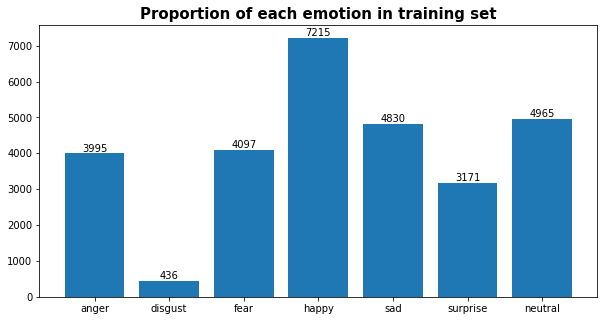

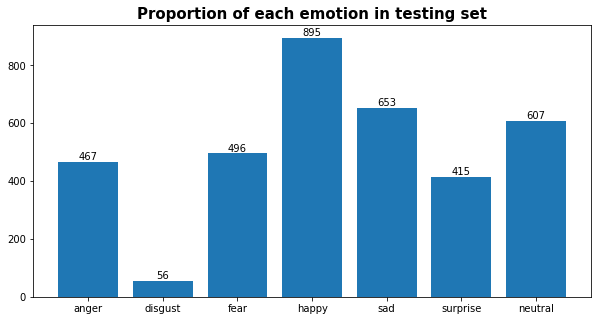

In [58]:
def show_frequency(dataset, title):
    # Showing figure
    fd = nltk.FreqDist(dataset)
    all_fdist = pd.Series(dict(fd)).sort_index(ascending=True)
    plt.subplots(figsize=(10,5))
    plt.bar(emotions, all_fdist)
    plt.title(title,fontweight="bold", size=15)
    
    # Adding labels to the bars
    for i, v in enumerate(all_fdist.values):
        plt.text(i, v, str(v), ha='center', va='bottom')
        
    plt.show()

show_frequency(y_train, "Proportion of each emotion in training set")
show_frequency(y_test, "Proportion of each emotion in testing set")

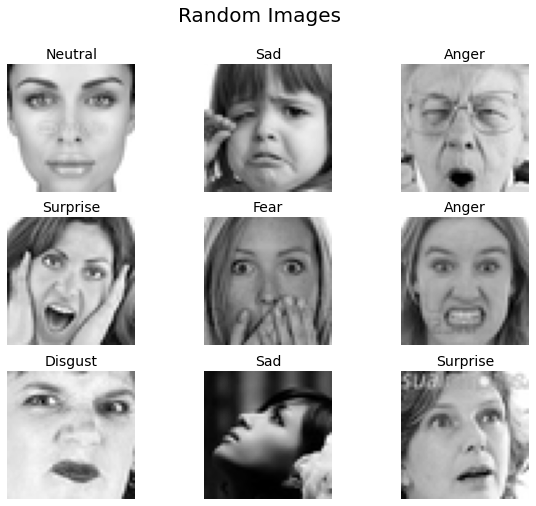

In [59]:
def show_image(x, y, title, num_images=9):
    emotion_mapping = {0: "Anger", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

    idx = np.random.choice(len(x), size=num_images, replace=False)
    x_sample = x[idx]
    y_sample = y[idx]

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
    fig.suptitle(title, fontsize=20)

    for i in range(num_images):
        img = x_sample[i][0]
        label = emotion_mapping[y_sample[i]]
        ax = axes[i // 3][i % 3]
        ax.imshow(img, cmap='gray')
        ax.set_title(label, fontsize=14)
        ax.axis('off')

    plt.show()

show_image(x_train,y_train, "Random Images")

In [60]:
class CNN(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN, self).__init__()

        # CONV => RELU => POOL => BATCH => DROPOUT layers
        
        # We have 1 channel because the pixels are grey
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            nn.BatchNorm2d(8)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            nn.BatchNorm2d(16)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            nn.BatchNorm2d(32)
        )
        
        self.fc1 = nn.Linear(64800, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 7)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.log_softmax = nn.LogSoftmax(dim=1)
        

    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.log_softmax(x)
        
        return x

In [61]:
def data_loader(x_data, y_data):
    data = []
    for i in range(len(x_data)):
        data.append([x_data[i], y_data[i]])
    
    dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
    return dataloader

def train(model,dataloader,epochs,loss_fn,optimizer):
    model.train()
    print("Training model ...\n")
    train_accuracy = []
    train_losses = []
    y_true_train = []
    y_pred_train = []
    
    for e in range(epochs):
        total_loss = 0
        total = 0
        correct = 0
        for i, (x, y) in enumerate(dataloader):
            
            x = x.float()
            x, y = x.to(device), y.to(device)

            output = model(x)
            
            loss = loss_fn(output, y)
            total_loss += loss.item()
            
            _, predicted = output.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
            
            y_true_train.extend(y.cpu().detach().numpy().tolist())
            y_pred_train.extend(predicted.cpu().detach().numpy().tolist())
            
            print("Total loss in epoch {} is {}".format(e+1, total_loss/(i+1)), end='\r')
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        train_loss = total_loss / len(dataloader)
        train_losses.append(train_loss)
        accuracy = 100. * correct / total
        train_accuracy.append(accuracy)
    
    f1_train = f1_score(y_true_train, y_pred_train, average='macro')
    recall_train = recall_score(y_true_train, y_pred_train, average='macro')
    precision_train = precision_score(y_true_train, y_pred_train, average='macro')
    
    print()
    print("Train accuracy is ", accuracy)
    print("Train F1-score is ", f1_train)
    print("Train recall is ", recall_train)
    print("Train precision is ", precision_train)

    return model

def test(model,dataloader,epochs,loss_fn,optimizer):
    print("Testing model ...\n")
    test_accuracy = []
    test_losses = []
    y_true_test = []
    y_pred_test = []
    
    # switch off autograd for evaluation
    for e in range(epochs):
        total_loss = 0
        total = 0
        correct = 0
        with torch.no_grad():
            model.eval()

            for i, (x, y) in enumerate(dataloader):

                x = x.float()
                x, y = x.to(device), y.to(device)

                output = model(x)

                total_loss += loss_fn(output, y).item()
                
                _, predicted = output.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()
                
                y_true_test.extend(y.cpu().detach().numpy().tolist())
                y_pred_test.extend(predicted.cpu().detach().numpy().tolist())
                
                print("Total loss in epoch {} is {}".format(e+1, total_loss/(i+1)), end='\r')
                
        test_loss = total_loss / len(dataloader)
        test_losses.append(test_loss)
        accuracy = 100. * correct / total
        test_accuracy.append(accuracy)
    
    f1_test = f1_score(y_true_test, y_pred_test, average='macro')
    recall_test = recall_score(y_true_test, y_pred_test, average='macro')
    precision_test = precision_score(y_true_test, y_pred_test, average='macro')
    
    print()
    print("Test accuracy is ", accuracy)
    print("Test F1-score is ", f1_test)
    print("Test recall is ", recall_test)
    print("Test precision is ", precision_test)

    return y_true_test, y_pred_test

In [62]:
# We set the hyperparameters
BATCH_SIZE = 128
EPOCHS = 20
LR = 0.0001
loss_fn = nn.CrossEntropyLoss()
CNN_model = CNN().to(device)
optimizer = optim.Adam(CNN_model.parameters(), lr=LR)

In [63]:
# Loading processed datasets
train_loader = data_loader(x_train,y_train)
test_loader = data_loader(x_test,y_test)

In [64]:
model = train(CNN_model,train_loader,EPOCHS,loss_fn,optimizer)
# Save model
#torch.save(model, "model.pt")

Training model ...

Total loss in epoch 20 is 0.038727081968035135
Train accuracy is  99.12570970775715
Train F1-score is  0.8928183937604294
Train recall is  0.8815917494472315
Train precision is  0.9063719568974159


In [65]:
y_true, y_pred = test(CNN_model,test_loader,EPOCHS,loss_fn,optimizer)

Testing model ...

Total loss in epoch 20 is 2.6452307927197425
Test accuracy is  51.992198383950964
Test F1-score is  0.5133969176885799
Test recall is  0.49961241026011644
Test precision is  0.5437687255012943


In [66]:
print(classification_report(y_true, y_pred, target_names=emotions))

              precision    recall  f1-score   support

       anger       0.38      0.43      0.40      9340
     disgust       0.81      0.46      0.59      1120
        fear       0.40      0.36      0.38      9920
       happy       0.66      0.75      0.70     17900
         sad       0.42      0.42      0.42     13060
    surprise       0.66      0.71      0.68      8300
     neutral       0.47      0.38      0.42     12140

    accuracy                           0.52     71780
   macro avg       0.54      0.50      0.51     71780
weighted avg       0.51      0.52      0.51     71780



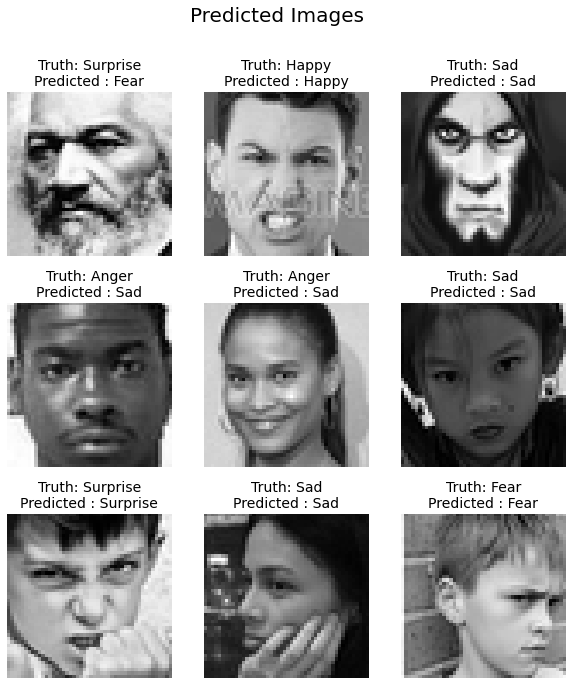

In [74]:
def show_model_predictions(y_true, y_pred, x, title, num_images=9):
    
    emotion_mapping = {0: "Anger", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

    idx = np.random.choice(len(x), size=num_images, replace=False)
    x_sample = x[idx]
    y_sample_true = np.array(y_true)[idx]
    y_sample_pred = np.array(y_pred)[idx]

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 11))
    fig.suptitle(title, fontsize=20)

    for i in range(num_images):
        img = x_sample[i][0]
        label_true = emotion_mapping[y_sample_true[i]]
        label_pred = emotion_mapping[y_sample_pred[i]]
        ax = axes[i // 3][i % 3]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Truth: {label_true}\nPredicted : {label_pred}', fontsize=14)
        ax.axis('off')

    plt.show()

show_model_predictions(y_true, y_pred, x_test, "Predicted Images")

# Additional experiments

In [101]:
def generate_new_images(x, y):
    class_counts = np.bincount(y)
    smaller_class = np.min(class_counts[np.nonzero(class_counts)])
    
    # create empty arrays to store new images and labels
    x_new = np.empty((0, 1, 48, 48), dtype=np.uint8)
    y_new = np.empty((0,), dtype=y.dtype)
    
    for class_label in range(len(class_counts)):
        x_class = x[y == class_label]
        num_images = len(x_class)
        
        # randomly choose smaller_class images from the class
        idx = np.random.choice(num_images, size=smaller_class, replace=False)
        x_class = x_class[idx]
        
        # create new images
        for i in range(len(x_class)):
            img = Image.fromarray(x_class[i][0].astype(np.uint8))
            img = np.array(img).reshape((1, 1, 48, 48))
            
            x_new = np.concatenate((x_new, img))
            y_new = np.concatenate((y_new, [class_label]))
            
            # create additional transformed images
            for j in range(10):
                transformed_img = Image.fromarray(x_class[i % len(x_class)][0].astype(np.uint8))
                scale_factor = random.uniform(0.8, 1.2)
                new_size = tuple([int(scale_factor * s) for s in transformed_img.size])
                transformed_img = transformed_img.resize(new_size)
                if random.random() < 0.5:
                    transformed_img = ImageOps.mirror(transformed_img)
                transformed_img = ImageEnhance.Brightness(transformed_img).enhance(random.uniform(0.5, 1.5))
                transformed_img = ImageOps.grayscale(transformed_img)
                transformed_img = transformed_img.rotate(random.randint(0, 360))
                transformed_img = transformed_img.transpose(random.randint(0, 3))
                transformed_img = transformed_img.resize((48, 48))
                transformed_img = np.array(transformed_img).reshape((1, 1, 48, 48))
                
                x_new = np.concatenate((x_new, transformed_img))
                y_new = np.concatenate((y_new, [class_label]))
    
    return x_new, y_new

In [103]:
x_train_new, y_train_new = generate_new_images(x_train, y_train)

In [104]:
x_test_new, y_test_new = generate_new_images(x_test, y_test)

In [105]:
def show_transformed_images(x, y, title, num_images=12):
    emotion_mapping = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))
    fig.suptitle(title, fontsize=20)

    for i in range(num_images):
        img = x[i][0]
        label = emotion_mapping[y[i]]

        # plot the transformed image and its emotion label
        ax = axes[i // 4][i % 4]
        ax.imshow(img, cmap='gray')
        ax.set_title(label, fontsize=14)
        ax.axis('off')

    plt.show()

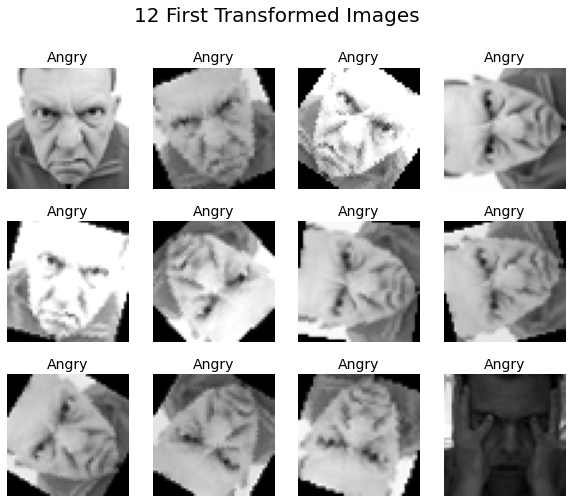

In [118]:
show_transformed_images(x_train_new, y_train_new, "12 First Transformed Images")

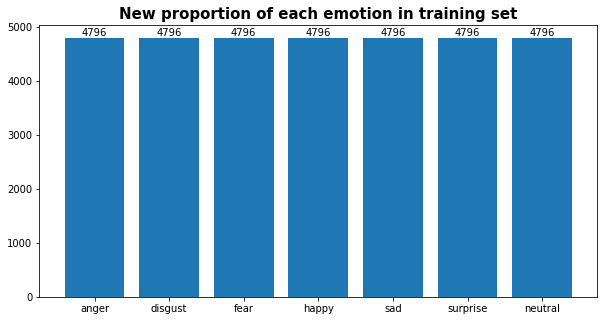

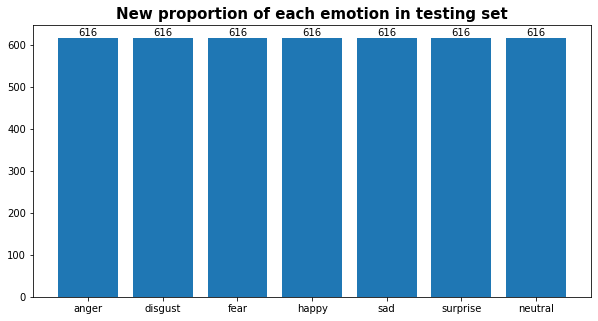

In [110]:
show_frequency(y_train_new, "New proportion of each emotion in training set")
show_frequency(y_test_new, "New proportion of each emotion in testing set")

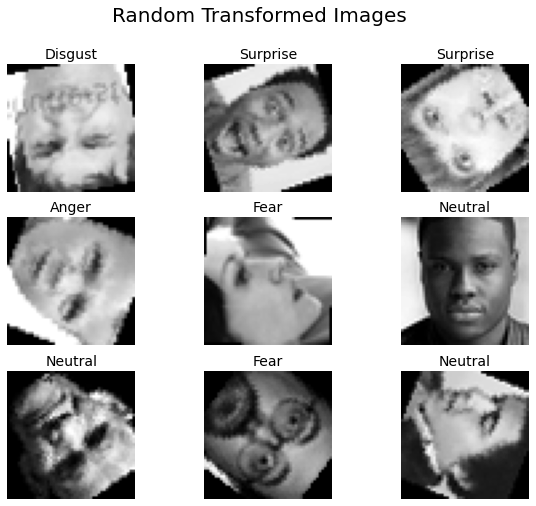

In [112]:
show_image(x_train_new,y_train_new,"Random Transformed Images")

In [113]:
train_loader_2 = data_loader(x_train_new,y_train_new)
test_loader_2 = data_loader(x_test_new,y_test_new)

In [114]:
model = train(CNN_model,train_loader_2,EPOCHS,loss_fn,optimizer)

Training model ...

Total loss in epoch 20 is 0.084150721481912724
Train accuracy is  97.1136661503634
Train F1-score is  0.8424999374194159
Train recall is  0.8426218277135707
Train precision is  0.8427190998953794


In [115]:
y_true_2, y_pred_2 = test(CNN_model,test_loader_2,EPOCHS,loss_fn,optimizer)
print(classification_report(y_true_2, y_pred_2, target_names=emotions))

Testing model ...

Total loss in epoch 20 is 3.7431862284155453
Test accuracy is  30.51948051948052
Test F1-score is  0.30542444423190773
Test recall is  0.3051948051948052
Test precision is  0.30789649549076703
              precision    recall  f1-score   support

       anger       0.21      0.27      0.24     12320
     disgust       0.44      0.44      0.44     12320
        fear       0.18      0.18      0.18     12320
       happy       0.40      0.38      0.39     12320
         sad       0.21      0.18      0.19     12320
    surprise       0.45      0.45      0.45     12320
     neutral       0.27      0.24      0.25     12320

    accuracy                           0.31     86240
   macro avg       0.31      0.31      0.31     86240
weighted avg       0.31      0.31      0.31     86240



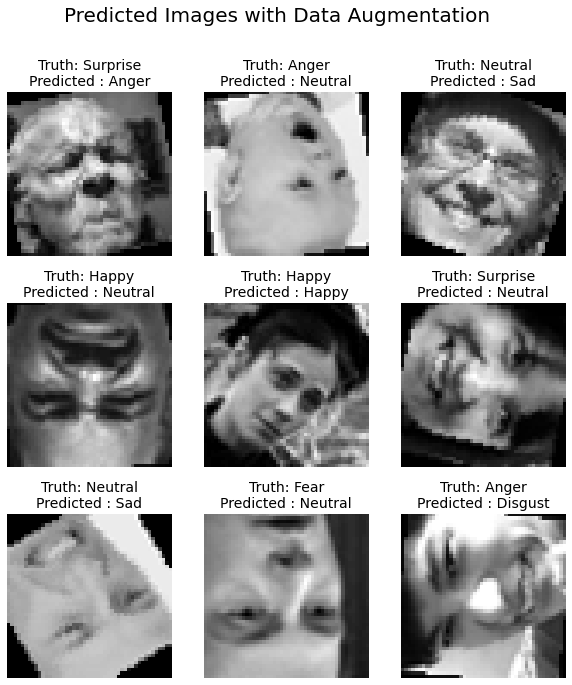

In [117]:
show_model_predictions(y_true_2, y_pred_2, x_test_new, "Predicted Images with Data Augmentation")